<a href="https://colab.research.google.com/github/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/05-making-transformers-efficient-in-production/case_study_intent_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Intent Detection: Case Study

Let’s suppose that we’re trying to build a text-based assistant for our company’s call center so
that customers can request the balance of their account or make bookings without needing to
speak with a human agent. In order to understand the goals of a customer, our assistant will
need to be able to classify a wide variety of natural language text into a set of predefined
actions or intents.

For example, a customer may send a message about an upcoming trip:

```txt
Hey, I’d like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van
```

and our intent classifier could automatically categorize this as a Car Rental intent, which then triggers an action and response.

To be robust in a production environment, our classifier will
also need to be able to handle out-of-scope queries.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/05-making-transformers-efficient-in-production/images/1.png?raw=1' width='600'/>

In the third case, the text-assistant
has been trained to detect out-of-scope queries (usually labelled as a separate class) and informs the customer about which topics they can respond to.

As a baseline we’ve fine-tuned a BERT-base model that achieves around `94%` accuracy on the
`CLINC150` dataset. This dataset includes `22,500` in-scope queries across `150` intents and `10`
domains like banking and travel, and also includes `1,200` out-of-scope queries that belong to an
oos intent class. In practice we would also gather our own in-house dataset, but using public
data is a great way to iterate quickly and generate preliminary results.



##Setup

In [ ]:
!pip -q install transformers[sentencepiece]
!pip -q install datasets

In [22]:
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline)
from transformers import TrainingArguments, Trainer
from datasets import load_dataset, load_metric

import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from time import perf_counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Now, let’s download our fine-tuned model from the Hugging Face Hub and wrap it in a pipeline for text classification:

In [ ]:
# molde path has changed: https://huggingface.co/transformersbook/bert-base-uncased-finetuned-clinc
bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_ckpt)
bert_model = (AutoModelForSequenceClassification.from_pretrained(bert_ckpt).to("cpu"))

bert_pipeline = TextClassificationPipeline(model=bert_model, tokenizer=bert_tokenizer)

Here we’ve set the model’s device to cpu since our text-assistant will need to operate in an
environment where queries are processed and responded to in real-time.

Now that we have a pipeline, we can pass a query to get the predicted intent and confidence
score from the model:

In [4]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van"""

bert_pipeline(query)

[{'label': 'car_rental', 'score': 0.5490034818649292}]

Great, the `car_rental` intent makes sense so let’s now look at creating a benchmark that we
can use to evaluate the performance of our baseline model.

##Performance Benchmark

Like any other machine learning model, deploying Transformers in production environments involves a trade-off among several constraints, the most common being:

- **Model performance**
  - How well does our model perform on a well-crafted test set that reflects production data?
- **Latency**
  - How fast can our model deliver predictions?
- **Memory**
  - How can we deploy billion-parameter models like GPT-2 or T5 that require gigabytes of disk storage and RAM?

Failing to address these constraints can have a negative impact on the user experience of your
application, or more commonly, lead to ballooning costs from running expensive cloud servers
that may only need to handle a few requests.

To explore how each of the these constraints can
be optimized with various compression techniques, let’s begin by creating a simple benchmark
that measures each quantity for a given pipeline and test set.

In [5]:
class PerformanceBenchmark:
  def __init__(self, pipeline, dataset, optim_type="BERT baseline") -> None:
    self.pipeline = pipeline
    self.dataset = dataset
    self.optim_type = optim_type

  def compute_accuracy(self):
    pass

  def compute_size(self):
    pass

  def time_pipeline(self):
    pass

  # We’ll use the run_benchmark function to collect all the metrics in a dictionary, with keys given by optim_type.
  def run_benchmark(self):
    metrics = {}
    metrics[self.optim_type] = self.compute_size()
    metrics[self.optim_type].update(self.time_pipeline())
    metrics[self.optim_type].update(self.compute_accuracy())
    return metrics

First we need some data to test on, so let’s download the CLINC150 dataset that was used to finetune our baseline model. 

We can get the dataset from the Hub with the Datasets library as follows:

In [6]:
clinc = load_dataset("clinc_oos", "plus")
clinc

Downloading:   0%|          | 0.00/2.75k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/291k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset clinc_oos downloaded and prepared to /root/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

Each example in the CLINC150 dataset consists of a query in the text column and its corresponding intent. 

We’ll use the test set to benchmark our models, so let’s take a look at one
of the dataset’s examples:

In [7]:
clinc["test"][42]

{'intent': 133, 'text': 'transfer $100 from my checking to saving account'}

The intents are provided as IDs, but we can easily get the mapping to strings (and vice versa)
by accessing the `Dataset.features` attribute:

In [8]:
intents = clinc["test"].features["intent"]
intents.int2str(clinc["test"][42]["intent"])

'transfer'

###Exploring Class distribution

Now that we have a basic understanding of the contents in the CLINC150 dataset, let’s check it class distribution.

In [9]:
clinc.set_format(type="pandas")

df = clinc["train"][:]
df.head()

,text,intent
0,what expression would i use to say i love you ...,61
1,can you tell me how to say 'i do not speak muc...,61
2,"what is the equivalent of, 'life is good' in f...",61
3,"tell me how to say, 'it is a beautiful morning...",61
4,"if i were mongolian, how would i say that i am...",61


In [10]:
def label_int2str(row, split):
  return clinc[split].features["intent"].int2str(row)

In [11]:
df["label_name"] = df["intent"].apply(label_int2str, split="train")
df.head()

,text,intent,label_name
0,what expression would i use to say i love you ...,61,translate
1,can you tell me how to say 'i do not speak muc...,61,translate
2,"what is the equivalent of, 'life is good' in f...",61,translate
3,"tell me how to say, 'it is a beautiful morning...",61,translate
4,"if i were mongolian, how would i say that i am...",61,translate


In [12]:
df["label_name"].value_counts(ascending=True)

car_rental          100
smart_home          100
shopping_list       100
no                  100
goodbye             100
                   ... 
definition          100
order_checks        100
ingredients_list    100
card_declined       100
oos                 250
Name: label_name, Length: 151, dtype: int64

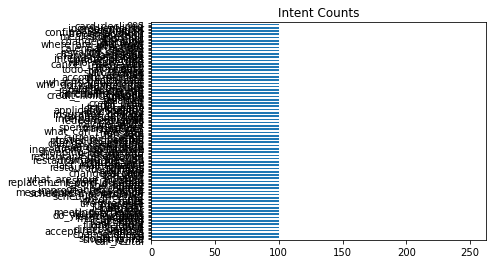

In [13]:
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Intent Counts");

In [14]:
# reset back to original format
clinc.reset_format()

###Updating Benchmark statistics

Since the dataset is balanced across the intent
classes, we’ll use accuracy as our metric which we can load from Datasets.

let’s implement the compute_accuracy function:

In [15]:
accuracy_score = load_metric("accuracy")
accuracy_score

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Metric(name: "accuracy", features: {'predictions': Value(dtype='int32', id=None), 'references': Value(dtype='int32', id=None)}, usage: """
Args:
    predictions: Predicted labels, as returned by a model.
    references: Ground truth labels.
    normalize: If False, return the number of correctly classified samples.
        Otherwise, return the fraction of correctly classified samples.
    sample_weight: Sample weights.
Returns:
    accuracy: Accuracy score.
Examples:

    >>> accuracy_metric = datasets.load_metric("accuracy")
    >>> results = accuracy_metric.compute(references=[0, 1], predictions=[0, 1])
    >>> print(results)
    {'accuracy': 1.0}
""", stored examples: 0)

The metric’s description tells us that we need to provide the predictions and references (i.e. the ground truth labels) as integers, so we can use the pipeline to extract the predictions from the
text field and then use the `ClassLabel.str2int` function to map the prediction to its corresponding ID.

So we need to collect all the predictions and labels in lists before
returning the accuracy on the dataset. 

Let’s also add it to our PerformanceBenchmark class:

In [16]:
def compute_accuracy(self):
  preds, labels = [], []
  for example in self.dataset:
    pred = self.pipeline(example["text"])[0]["label"]
    label = example["intent"]
    preds.append(intents.str2int(pred))
    labels.append(label)
  accuracy = accuracy_score.compute(predictions=preds, references=labels)
  print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
  return accuracy

# now update compute_accuracy method of PerformanceBenchmark class
PerformanceBenchmark.compute_accuracy = compute_accuracy

Next, let’s compute the size of our model by using the `torch.save` function from PyTorch to serialize the model to disk.In PyTorch,
the recommended way to save a model is by using its `state_dict`, which is a Python dictionary that maps each layer in a model to its learnable parameters (i.e. weights and biases).

Let’s see what is stored in the `state_dict` of our baseline model:

In [17]:
list(bert_pipeline.model.state_dict().items())[42]

('bert.encoder.layer.2.attention.self.value.weight',
 tensor([[-1.0526e-02, -3.2215e-02,  2.2097e-02,  ..., -6.0953e-03,
           4.6521e-03,  2.9844e-02],
         [-1.4964e-02, -1.0915e-02,  5.2396e-04,  ...,  3.2047e-05,
          -2.6890e-02, -2.1943e-02],
         [-2.9640e-02, -3.7842e-03, -1.2582e-02,  ..., -1.0917e-02,
           3.1152e-02, -9.7786e-03],
         ...,
         [-1.5116e-02, -3.3226e-02,  4.2063e-02,  ..., -5.2652e-03,
           1.1093e-02,  2.9703e-03],
         [-3.6809e-02,  5.6848e-02, -2.6544e-02,  ..., -4.0114e-02,
           6.7487e-03,  1.0511e-03],
         [-2.4961e-02,  1.4747e-03, -5.4271e-02,  ...,  2.0004e-02,
           2.3981e-02, -4.2880e-02]]))

We can clearly see that each key-value pair corresponds to a specific layer and tensor in BERT.

We can then use the Path.stat function from Python’s `pathlib` module to get information about the underlying files. In particular `Path(PATH).stat().st_size` will give us the model size in bytes, so let’s put this all together in the `compute_size` function and add it to PerformanceBenchmark:

In [18]:
def compute_size(self):
  state_dict = self.pipeline.model.state_dict()
  tmp_path = Path("model.pt")
  torch.save(state_dict, tmp_path)
  # Calculate size in megabytes
  size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
  # Delete temporary file
  tmp_path.unlink()
  print(f"Model size (MB) - {size_mb:.2f}")
  return {"size_mb": size_mb}

# now update compute_size method of PerformanceBenchmark class
PerformanceBenchmark.compute_size = compute_size

Finally let’s implement the `time_pipeline` function so that we can time the median latency
per query. For this application, latency refers to the time it takes to feed a text query to the
pipeline and return the predicted intent from the model.

Under the hood, the pipeline also
tokenizes the text but this is around 1,000 times faster than generating the predictions and thus
adds a negligible contribution to the overall latency.

A simple way to measure the time of a
code snippet is to use the `perf_counter` function from Python’s `time` module. This function has a better time resolution than the `time.time` function and so is well suited for getting precise results.

We can use `perf_counter` to time our `pipeline` by passing our test query and calculating the
time difference in milliseconds between the start and end:

In [19]:
for _ in range(3):
  start_time = perf_counter()
  _ = bert_pipeline(query)
  latency = perf_counter() - start_time
  print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 161.315
Latency (ms) - 124.255
Latency (ms) - 140.168


So instead,
we’ll collect the latencies over many runs and then use the resulting distribution to calculate the
mean and standard deviation, which will give us an idea about the spread in values. 

The following code does what we need and includes a phase to warm-up the CPU before performing the actual timed run:

In [20]:
def time_pipeline(self, query="What is the pin number for my account?"):
  latencies = []
  # Warmup
  for _ in range(10):
    _ = self.pipeline(query)
  # Timed run
  for _ in range(100):
    start_time = perf_counter()
    _ = bert_pipeline(query)
    latency = perf_counter() - start_time
    latencies.append(latency)
  # Compute run statistics
  time_avg_ms = 1000 * np.mean(latencies)
  time_std_ms = 1000 * np.std(latencies)
  print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
  return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

# now update time_pipeline method of PerformanceBenchmark class
PerformanceBenchmark.time_pipeline = time_pipeline

###Benchmarking Our Baseline Model

Now that our `PerformanceBenchmark` is complete, let’s give it a spin! For the baseline
model we just need to pass the pipeline and dataset we wish to perform the benchmark on, and
we’ll collect the results in the `perf_metrics` dictionary to keep track of each model’s
performance:

In [21]:
pb = PerformanceBenchmark(bert_pipeline, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.16
Average latency (ms) - 83.24 +\- 3.82
Accuracy on test set - 0.867


Once we have determined the best performing model we can then explore different backends to reduce the absolute latency if needed.

Now that we have a reference point, let’s look at our first compression technique: **knowledge distillation**.

##Knowledge Distillation for Models Smaller

Knowledge distillation is a general-purpose method for training a smaller student model to mimic the behavior of a slower, larger, but better performing teacher.

###Knowledge Distillation for Fine-tuning

For supervised tasks like fine-tuning, the main idea is to augment the ground truth labels with a distribution of `soft probabilities` from the teacher which provide complementary information for the student to learn from. 

For example, if our BERT-base classifier assigns high
probabilities to multiple intents, then this could be a sign that these intents lie close to each
other in the feature space. By training the student to mimic these probabilities, the goal is to
distill some of this `dark knowledge` that the teacher has learnt; knowledge which is not available from the labels alone.

Mathematically, the way this works is as follows. Suppose we feed an input sequence x to the teacher to generate a vector of logits $z(x) = [z_1 (x), ..., z_N (x)]$. We can convert these logits into probabilities by applying a softmax function:

$$
\frac{exp(z_i(x))}{\sum_j{exp(z_i(x))}}
$$

but this isn’t quite what we want because in many cases the teacher will assign a high
probability to one class, with all other class probabilities close to zero.

When that happens, the
teacher doesn’t provide much additional information beyond the ground truth labels, so instead
we `soften` the probabilities by scaling the logits with a positive temperature hyperparameter
$T$ before applying the softmax:

$$
p_i(x) = \frac{exp(z_i(x)/T)}{\sum_j{exp(z_i(x)/T)}}
$$

As shown, higher values of $T$ produce a softer probability distribution over the classes and reveal much more information about the decision boundary that the teacher has learned for each training example. When $T = 1$ we recover the original softmax distribution.

<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/05-making-transformers-efficient-in-production/images/2.png?raw=1' width='600'/>

Since the student also produces softened probabilities $q_i(x)$ of its own we can use the Kullback-Leibler (KL) divergence:

$$
D_{KL}(p, q) = \sum_i p_i(x)log\frac{p_i(x)}{q_i(x)}
$$

to measure the difference between the two probability distributions and thereby define a knowledge distillation loss:

$$
L_{KD} = T^2 D_{KL} = T^2 \sum_i p_i(x)log\frac{p_i(x)}{q_i(x)}
$$

where $T^2$ is a normalization factor to account for the fact that the magnitude of the gradients produced by soft labels scales as $1/T^2$. 

For classification tasks, the student loss is then a weighted average of the distillation loss with the usual cross-entropy  $loss_{CE}$ of the ground truth labels:

$$
L_{student} = \alpha L_{CE} + (1 - \alpha) L_{KD}
$$

where $\alpha$ is a hyperparameter that controls the relative strength of each loss.

A diagram of the whole process is shown below and the temperature is set to 1 at inference time to recover the standard softmax probabilities.


<img src='https://github.com/rahiakela/transformers-research-and-practice/blob/main/natural-language-processing-with-transformers/05-making-transformers-efficient-in-production/images/3.png?raw=1' width='600'/>


###Knowledge Distillation for Pretraining

Knowledge distillation can also be used during pretraining to create a general-purpose student
that can be subsequently fine-tuned on downstream tasks. In this case, the teacher is a
pretrained language model like BERT which transfers its knowledge about masked-languagemodeling
to the student. 

For example, in the DistilBERT paper, the masked-languagemodeling
loss $L_{mlm}$ is augmented with a term from knowledge distillation and a cosine
embedding loss $L_{cos} = 1− cos (h_s, h_t)$ to align the directions of the hidden state vectors between the teacher and student:

$$L_{DistilBERT} = \alpha L_{mlm} + \beta L_{KD} + \gamma L_{cos}$$

Since we already have a fine-tuned BERT-base model, let’s see how we can use knowledge distillation to fine-tune a smaller and faster model. To do that we’ll need a way to augment the cross-entropy loss with a $L_{KD}$ term; fortunately we can do this by creating our own trainer!

####Knowledge Distillation Trainer

To implement knowledge distillation we need to add a few things to the `Trainer` base class:

- The new hyperparameters $\alpha$ and $T$ which control the relative weight of the distillation loss and how much the probability distribution of the labels should be smoothed.
- The fine-tuned teacher model, which in our case is `BERT-base`
- A new loss function that includes the cross-entropy loss with the knowledge
distillation loss.

Adding the new hyperparameters is quite simple since we just need to subclass
`TrainingArguments` and include them as new attributes:

In [23]:
class DistillationTrainingArguments(TrainingArguments):
  def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
    super().__init__(*args, **kwargs)
    self.alpha = alpha
    self.temperature = temperature

For the trainer itself, we want a new loss function so the way to implement this is by subclassing `Trainer` and overriding the `compute_loss` function to include the knowledge distillation loss term $L_{KD}$:

In [25]:
class DistillationTrainer(Trainer):
  def __init__(self, *args, teacher_model=None, **kwargs):
    super().__init__(*args, **kwargs)
    self.teacher_model = teacher_model

  def compute_loss(self, model, inputs):
    outputs_student = model(**inputs)
    # Extract cross-entropy loss and logits from student
    loss_ce = outputs_student.loss
    logits_student = outputs_student.logits
    # Extract logits from teacher
    with torch.no_grad():
      outputs_teacher = self.teacher_model(**inputs)
      logits_teacher = outputs_teacher.logits
    # Soften probabilities and compute distillation loss
    loss_kld = nn.KLDivLoss(reduction="batchmean")
    loss_kd = self.args.temperature ** 2 * loss_kld(
        F.log_softmax(logits_student / self.args.temperature, dim=-1),
        F.softmax(logits_teacher / self.args.temperature, dim=-1)
    )
    # Return weighted student loss
    self.args.alpha * loss_ce + (1 - self.args.alpha) * loss_kd

When we instantiate `DistillationTrainer`, we pass a `teacher_model` argument with a teacher that has already been fine-tuned on our task. 

Next, in the `compute_loss` function we extract the logits from the student and teacher, scale them
by the temperature and then normalize them with a softmax before passing them to PyTorch’s `nn.KLDivLoss` function for computing the KL divergence. 
Since `nn.KLDivLoss` expects the inputs in the form of `log-probabilities`, we’ve used the `F.log_softmax` function to
normalize the student’s logits, while the teacher’s logits are converted to probabilities with a standard softmax. The `reduction=batchmean` argument in `nn.KLDivLoss` specifies that we average the losses over the batch dimension.

####Student Initialization